No relevant file, loading original from data/8_29_kitchen_scene/spad/data_accum.mat
Saving to data/8_29_kitchen_scene/spad_relevant.npy
min depth, max_depth
0.3984 9.0024
166 3750
(3, 510, 510)
[   0.           3.7372437    7.5586243   11.466095    15.461548
   19.546982    23.724411    27.99591     32.3636      36.82965
   41.396286    46.065735    50.840378    55.72255     60.714615
   65.81914     71.038605    76.375595    81.83281     87.41292
   93.11867     98.952896   104.91853    111.01851    117.255875
  123.63365    130.1551     136.82341    143.64186    150.6139
  157.7429     165.03246    172.48622    180.10777    187.90102
  195.86974    204.0179     212.3496     220.86888    229.58003
  238.48738    247.59523    256.90826    266.43103    276.1682
  286.12463    296.30536    306.71533    317.35974    328.24377
  339.37305    350.75287    362.38904    374.2871     386.45325
  398.8933     411.61353    424.62024    437.9198     451.5188
  465.4242     479.64258    494.18127 

(-0.5, 863.5, 767.5, -0.5)

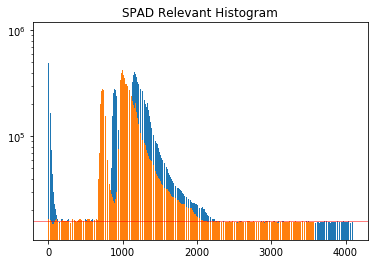

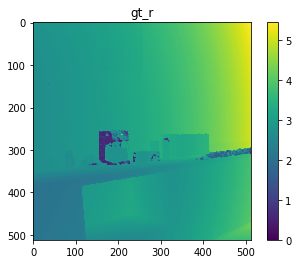

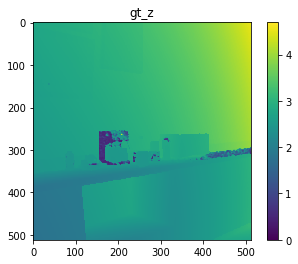

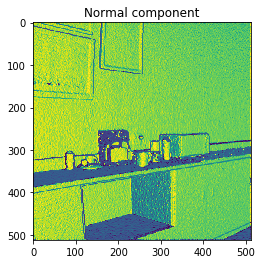

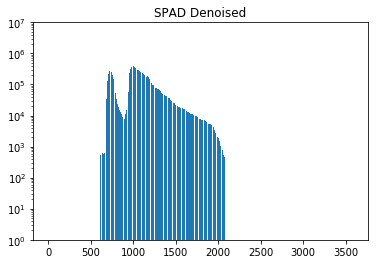

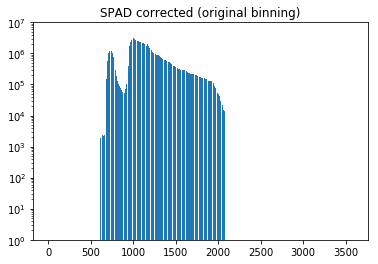

<Figure size 432x288 with 0 Axes>

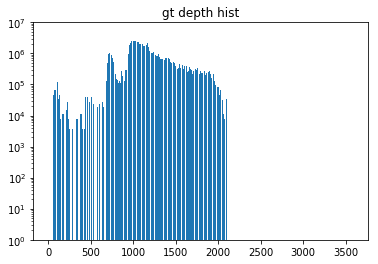

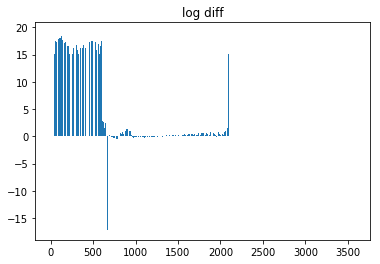

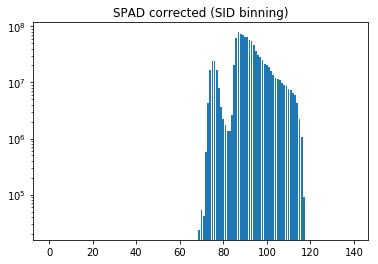

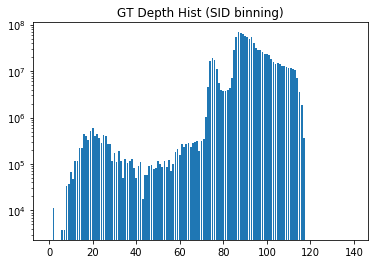

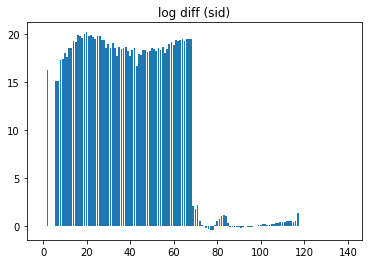

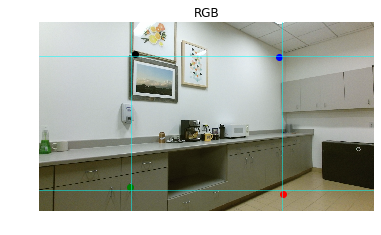

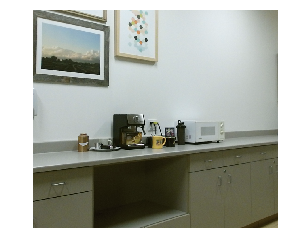

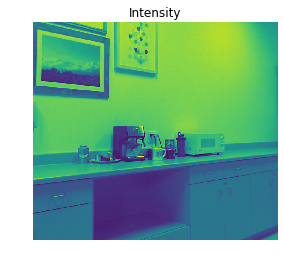

In [125]:
# Imports and hyperparams
%matplotlib inline
import os
import cv2
import numpy as np
import scipy.io as sio
from DenseDepthModel import DenseDepth
from DORN import DORN
from MiDaSModel import get_midas, midas_predict
from capture_utils import loadmat_h5py, z_to_r, r_to_z, rescale_bins, normals_from_depth, fc_kinect, fc_spad
from models.data.data_utils.sid_utils import SID
from remove_dc_from_spad import remove_dc_from_spad_edge
from weighted_histogram_matching import image_histogram_match
# from spad_utils import rescale_bins
import h5py
import matplotlib.pyplot as plt
rootdir = "data/8_29_kitchen_scene"

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

loaded_orig = False

# Load SPAD data
relevant_file = os.path.join(rootdir, "spad_relevant.npy")
force_refresh = True
if os.path.isfile(relevant_file) and not force_refresh:
    print("Loading from {}".format(relevant_file))
    spad_relevant_dict = np.load(relevant_file, allow_pickle=True).item()
    spad_relevant = spad_relevant_dict["spad_relevant"]
    min_depth_bin = spad_relevant_dict["min_depth_bin"]
    max_depth_bin = spad_relevant_dict["max_depth_bin"]
else:
    orig_file = os.path.join(rootdir, "spad", "data_accum.mat")
    print("No relevant file, loading original from {}".format(orig_file))
    spad = loadmat_h5py(orig_file)
    # No relevant file yet, so plotting:
    spad_single = np.sum(spad["mat"], axis=(0,1))
    plt.bar(range(len(spad_single)), spad_single, log=True)
    plt.title("SPAD Histogram (full range)")
    loaded_orig = True
#     spad_relevant = spad["mat"][..., min_depth_bin:max_depth_bin]
#     np.save(os.path.join(rootdir, "spad_relevant.npy"), spad_relevant)
# Inspect SPAD, set min and max depths, and set the ambient estimate
# Extract relevant subset of SPAD and save
bin_width_ps = 16  # Bin width is 16 ps
bin_width_m = bin_width_ps*3e8/(2*1e12)
if loaded_orig:
    # Adjust parameters here
    min_depth_bin = np.floor(0.4/bin_width_m).astype('int')
    max_depth_bin = np.floor(9./bin_width_m).astype('int')
    spad_relevant = spad["mat"][..., min_depth_bin:max_depth_bin]
    spad_relevant_dict = {
        "spad_relevant": spad_relevant,
        "min_depth_bin": min_depth_bin,
        "max_depth_bin": max_depth_bin
    }
    print("Saving to {}".format(os.path.join(rootdir, "spad_relevant.npy")))
    np.save(os.path.join(rootdir, "spad_relevant.npy"), spad_relevant_dict)
min_depth = min_depth_bin*bin_width_m
max_depth = (max_depth_bin+1)*bin_width_m
print("min depth, max_depth")
print(min_depth, max_depth)
print(min_depth_bin, max_depth_bin)
    
# Plot to visualize the clipping
spad_single_relevant = np.sum(spad_relevant, axis=(0,1))
plt.bar(range(len(spad_single_relevant)), spad_single_relevant, log=True)
plt.title("SPAD Relevant Histogram")

# Estimate ambient level:
ambient_max_depth = 100
ambient_estimate = np.mean(spad_single_relevant[:ambient_max_depth])
plt.axhline(y=ambient_estimate, color='r', linewidth=0.5)




# Get Ground truth depth
import scipy.signal as signal
gt_idx = np.argmax(spad_relevant, axis=2)
gt_r = signal.medfilt(np.fliplr(np.flipud(((gt_idx + min_depth_bin) * bin_width_m).T)), kernel_size=5)
plt.figure()
plt.imshow(gt_r)
plt.title("gt_r")
plt.colorbar()

gt_z = r_to_z(gt_r, fc_spad)
plt.figure()
plt.imshow(gt_z)
plt.colorbar()
plt.title("gt_z")

# Extract surface normals and compute new weights
gt_n = normals_from_depth(gt_r)
print(gt_n.shape)
normals = np.zeros((gt_n.shape[1]+2, gt_n.shape[2]+2))
normals[1:-1, 1:-1] = gt_n[2,...]
plt.figure()
plt.imshow(normals, vmin=0., vmax=1.)
plt.title("Normal component")

# Preprocess SPAD
sid_obj = SID(sid_bins=140, alpha=min_depth, beta=max_depth, offset=0)

vmin = 1e0
vmax = 1e7

# Remove DC
spad_denoised = remove_dc_from_spad_edge(spad_single_relevant, ambient_estimate)
plt.figure()
plt.bar(range(len(spad_denoised)), spad_denoised, log=True)
plt.ylim(vmin, vmax)
plt.title("SPAD Denoised")

# Correct Falloff
bin_edges = np.linspace(min_depth, max_depth, len(spad_denoised) + 1)
bin_values = (bin_edges[1:] + bin_edges[:-1])/2
spad_corrected = spad_denoised * bin_values ** 2
plt.figure()
plt.bar(range(len(spad_corrected)), spad_corrected, log=True)
plt.ylim(vmin, vmax)
plt.title("SPAD corrected (original binning)")

# GT Depth Histogram for reference
gt_r_hist, _ = np.histogram(gt_r, range=(min_depth, max_depth), bins=spad_relevant.shape[2])
plt.figure()
gt_r_hist_scaled = gt_r_hist * np.sum(spad_corrected)/np.sum(gt_r_hist)
plt.figure()
plt.bar(range(len(gt_r_hist)), gt_r_hist_scaled, log=True)
plt.ylim(vmin, vmax)
plt.title("gt depth hist")

# Log difference plot for reference:
log_diff = np.log(gt_r_hist_scaled+1e-3) - np.log(spad_corrected+1e-3)
plt.figure()
plt.bar(range(len(log_diff)), log_diff)
plt.title("log diff")

# Convert to SID
spad_sid = rescale_bins(spad_corrected, min_depth, max_depth, sid_obj)
plt.figure()
plt.bar(range(len(spad_sid)), spad_sid, log=True)
plt.title("SPAD corrected (SID binning)");

# GT Depth SID Histogram for reference
gt_r_hist_sid = rescale_bins(gt_r_hist_scaled, min_depth, max_depth, sid_obj)
plt.figure()
plt.bar(range(len(gt_r_hist_sid)), gt_r_hist_sid, log=True)
plt.title("GT Depth Hist (SID binning)");

# Log diff sid
log_diff_sid = np.log(gt_r_hist_sid + 1e-3) - np.log(spad_sid + 1e-3)
plt.figure()
plt.bar(range(len(log_diff_sid)), log_diff_sid)
plt.title("log diff (sid)");

# RGB Images
# Calibration data
print("Loading calibration data...")
calib = loadmat_h5py(os.path.join(rootdir, "calibration.mat"))

print("Loading kinect data...")
kinect = loadmat_h5py(os.path.join(rootdir, "kinect.mat"))
# Transpose and visualize
plt.figure()
kinect_rgb = np.fliplr(kinect["rgb_im"].transpose(2, 1, 0))
plt.imshow(kinect_rgb)
plt.title("RGB")
plt.axis("off")
plt.plot(calib["pos_00"][1], calib["pos_00"][0], "ro")
plt.plot(calib["pos_01"][1], calib["pos_01"][0], "bo")
plt.plot(calib["pos_10"][1], calib["pos_10"][0], "go")
plt.plot(calib["pos_11"][1], calib["pos_11"][0], "ko")

# print(calib["pos_00"]) # position 0 is the row, position 1 is the column
# Extract crop
top = (calib["pos_01"][0] + calib["pos_11"][0])//2
bot = (calib["pos_10"][0] + calib["pos_00"][0])//2
left = (calib["pos_11"][1] + calib["pos_10"][1])//2
right = (calib["pos_01"][1] + calib["pos_00"][1])//2

# Scene-specific crop
crop = (int(top[0])+3, int(bot[0])-2, int(left[0])-7, int(right[0])+6)
print((crop[1] - crop[0]) % 32)
print((crop[3] - crop[2]) % 32)
plt.axhline(y=crop[0], color='cyan', linewidth=0.5)
plt.axhline(y=crop[1], color='cyan', linewidth=0.5)
plt.axvline(x=crop[2], color='cyan', linewidth=0.5)
plt.axvline(x=crop[3], color='cyan', linewidth=0.5)

# Kinect Depth - don't use for now
# plt.figure()
# kinect_depth = np.fliplr(kinect["depth_im"].transpose(1, 0))
# plt.imshow(kinect_depth)
# plt.title("Kinect Depth")
# plt.axis("off");

# Crop
rgb_cropped = kinect_rgb[crop[0]:crop[1], crop[2]:crop[3], :]
plt.figure()
plt.imshow(rgb_cropped)
plt.axis("off")

# Intensity
intensity = rgb_cropped[:,:,0]/225.
plt.figure()
plt.imshow(intensity)
plt.title("Intensity")
plt.axis("off")



In [126]:
# Mask
gt_r[gt_r == 0] = 1e-3  # Clip to avoid numerical issues
mask = (gt_r > 2.).astype('float')

In [152]:
crop

(193, 961, 528, 1392)

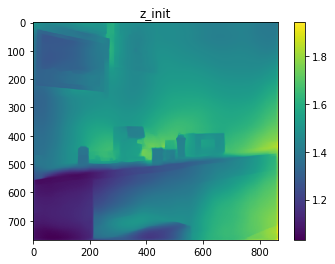

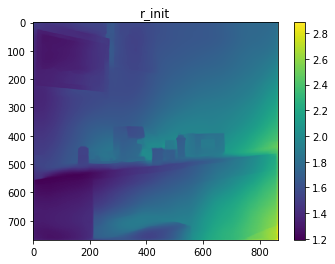

In [131]:
# Run RGB through CNN
# midas_model = get_midas(model_path="MiDaS/model.pt", device="cpu")
# z_init = midas_predict(midas_model, rgb_cropped/255., depth_range=(min_depth, max_depth), device="cpu")
# densedepth_model = DenseDepth()
z_init = densedepth_model.predict(rgb_cropped).squeeze()


plt.figure()
plt.imshow(z_init)
plt.title("z_init")
plt.colorbar()

# Convert to radial distance
# Scale to be in the right range
r_init = z_to_r(z_init, fc_kinect)
# r_init = (max_depth - min_depth)*(r_init-np.min(r_init))/(np.max(r_init) - np.min(r_init)) + \
#          min_depth
plt.figure()
plt.imshow(r_init)
plt.title("r_init")
plt.colorbar()



Text(0.5, 1.0, 'gt_r_hist_sid')

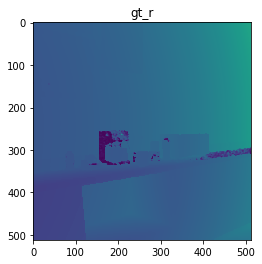

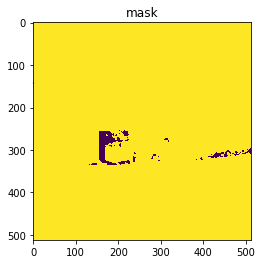

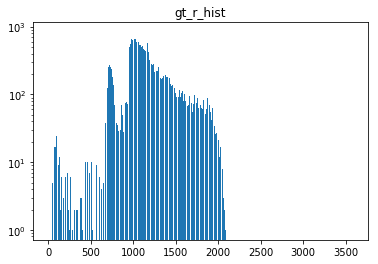

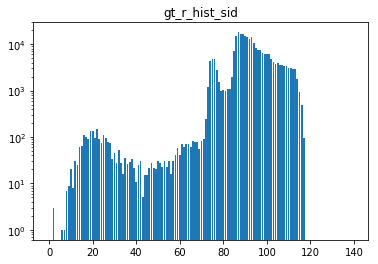

In [132]:
# Ground truth depth and histogram, SID and linear
plt.figure()
plt.imshow(gt_r, vmin=min_depth, vmax=max_depth)
plt.title("gt_r")

plt.figure()
plt.imshow(mask)
plt.title("mask")

def get_sid_hist(img, sid_obj, mask=None):
    if mask is not None:
        img = img[mask > 0.]
    hist, _ = np.histogram(img, bins=sid_obj.sid_bin_edges)
    return hist
    
def get_lin_hist(img, min_depth, max_depth, nbins, mask=None):
    if mask is not None:
        img = img[mask > 0.]
    hist, _ = np.histogram(img, range=(min_depth, max_depth), bins=nbins)
    return hist

gt_r_hist = get_lin_hist(gt_r, min_depth, max_depth, max_depth_bin-min_depth_bin)
gt_r_hist_sid = get_sid_hist(gt_r, sid_obj)

plt.figure()
plt.bar(range(len(gt_r_hist)), gt_r_hist, log=True)
plt.title("gt_r_hist")

plt.figure()
plt.bar(range(len(gt_r_hist_sid)), gt_r_hist_sid, log=True)
plt.title("gt_r_hist_sid")


        d1,         d2,         d3,        rel,       rmse,     log_10
    0.0020,     0.0354,     0.5286,     0.4827,     1.5029,     0.2911


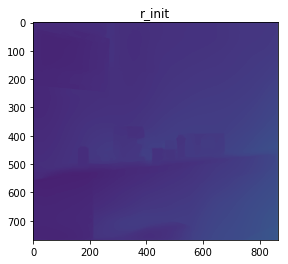

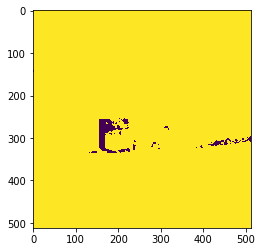

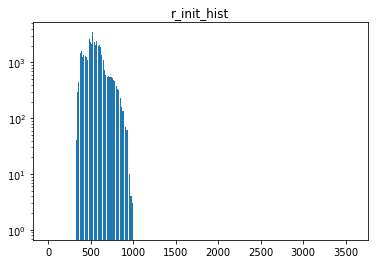

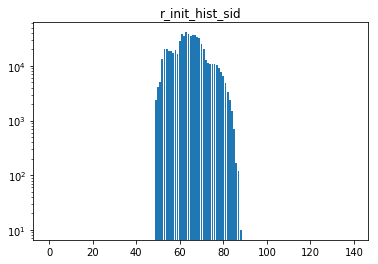

In [134]:
# Initial Image and histograms (SID and linear)
plt.figure()
plt.imshow(r_init, vmin=min_depth, vmax=max_depth)
plt.title("r_init")

plt.figure()
plt.imshow(mask)

r_init_hist = get_lin_hist(r_init, min_depth, max_depth, max_depth_bin-min_depth_bin)
r_init_hist_sid = get_sid_hist(r_init, sid_obj)
plt.figure()
plt.bar(range(len(r_init_hist)), r_init_hist, log=True)
plt.title("r_init_hist")

plt.figure()
plt.bar(range(len(r_init_hist_sid)), r_init_hist_sid, log=True)
plt.title("r_init_hist_sid")

z_init = r_to_z(r_init, fc_kinect)
z_init_resized = cv2.resize(z_init, gt_z.shape)
pred_metrics = get_depth_metrics(torch.from_numpy(z_init_resized).float(),
                  torch.from_numpy(gt_z).float(),
                  torch.from_numpy(mask).float())
pprint_metrics(pred_metrics)


In [7]:
# Weighted Histogram Matching
def find_movement(hist_from, hist_to):
    """Gives the movements from hist_from (column sum)
    to hist_to (row sum).

    Based on Morovic et. al 2002 A fast, non-iterative, and exact histogram matching algorithm.

    hist_from and hist_to should sum to the same value
    """
    movement = np.zeros((len(hist_from), len(hist_to)))
    for row in range(len(hist_from)):
        for col in range(len(hist_to)):
            pixels_rem = hist_from[row] - np.sum(movement[row, :col])
            pixels_req = hist_to[col] - np.sum(movement[:row, col])
            # if np.minimum(pixels_rem, pixels_req) < 0:
            #     print(row, col)
            #     print(hist_from[row])
            #     print(hist_to[col])
            #     print(pixels_rem, pixels_req)
            #     raise Exception()
            movement[row, col] = np.clip(np.minimum(pixels_rem, pixels_req), a_min=0., a_max=None)
    return movement


def move_pixels(T, init_index, weights):
    assert init_index.shape == weights.shape
    pred_index = np.zeros_like(init_index)
    cpfs = np.cumsum(T, axis=1)

    
    for row in range(init_index.shape[0]):
        for col in range(init_index.shape[1]):
            i = init_index[row, col]
            cpf = cpfs[i]
            p = np.random.uniform(0, cpf[-1])
            for j in range(len(cpf)):
                if cpf[j] >= p:
                    pred_index[row, col] = j
                    if T[i,j] > weights[row, col]:
                        # Leave some small positive mass here so that future pixels don't clip to 0.
                        T[i, j] = T[i, j] - weights[row, col]
                    break
    return pred_index


def move_pixels_vectorized(T, init_index, weights):
    assert init_index.shape == weights.shape
    pred_index = np.zeros_like(init_index)
    cpfs = np.cumsum(T, axis=1)  # Sum across columns
    pixel_cpfs = cpfs[init_index, :]  # Per-pixel cpf, cpf goes along axis 2
    p = np.random.uniform(0., pixel_cpfs[..., -1], size=init_index.shape)  # Generate 1 random number for each pixel
    # Use argmax trick to get first index k where p[i,j] < pixel_cpfs[i,j,k] for all i,j
    pred_index = (np.expand_dims(p, 2) < pixel_cpfs).argmax(axis=2)
    return pred_index

def image_histogram_match(init, gt_hist, weights, sid_obj):
    weights = weights * (np.sum(gt_hist) / np.sum(weights))
    init_index = np.clip(sid_obj.get_sid_index_from_value(init), a_min=0, a_max=sid_obj.sid_bins - 1)
    init_hist, _ = np.histogram(init_index, weights=weights, bins=range(sid_obj.sid_bins + 1))
    if (gt_hist < 0).any():
        print("Negative values in gt_hist")
        raise Exception()
    T_count = find_movement(init_hist, gt_hist)
#     pred_index = move_pixels_raster(T_count, init_index, weights)
#     pred_index = move_pixels(T_count, init_index, weights)
#     pred_index = move_pixels_better(T_count, init_index, weights)
    pred_index = move_pixels_vectorized(T_count, init_index, weights)
    pred = sid_obj.get_value_from_sid_index(pred_index)
    pred_hist, _ = np.histogram(pred_index, weights=weights, bins=range(len(gt_hist) + 1))
    return pred, (init_index, init_hist, pred_index, pred_hist, T_count)

def image_histogram_match_lin(init, gt_hist, weights, min_depth, max_depth):
    weights = weights * (np.sum(gt_hist) / np.sum(weights))
    n_bins = len(gt_hist)
    bin_edges = np.linspace(min_depth, max_depth, n_bins + 1)
    bin_values = (bin_edges[1:] + bin_edges[:-1])/2
    init_index = np.clip(np.floor((init - min_depth)*n_bins/(max_depth - min_depth)),
                         a_min=0., a_max=n_bins-1).astype('int')
    init_hist, _ = np.histogram(init_index, weights=weights, bins=range(n_bins+1))
    if (gt_hist < 0).any():
        print("Negative values in gt_hist")
        raise Exception()
    T_count = find_movement(init_hist, gt_hist)
#     pred_index = move_pixels_raster(T_count, init_index, weights)
#     pred_index = move_pixels(T_count, init_index, weights)
#     pred_index = move_pixels_better(T_count, init_index, weights)
    pred_index = move_pixels_vectorized(T_count, init_index, weights)
    pred = np.take(bin_values, pred_index)
    pred_hist, _ = np.histogram(pred_index, weights=weights, bins=range(n_bins+1))
    return pred, (init_index, init_hist, pred_index, pred_hist, T_count)

In [8]:
# Metrics
# Calculate metrics, plot results, generate figures
import torch
import cv2
from models.loss import get_depth_metrics
def pprint_metrics(metrics):
    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('d1', 'd2', 'd3', 'rel', 'rmse', 'log_10'))
    print(
        "{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(metrics["delta1"],
                                                                            metrics["delta2"],
                                                                            metrics["delta3"],
                                                                            metrics["rel_abs_diff"],
                                                                            metrics["rmse"],
                                                                            metrics["log10"]))

    

        d1,         d2,         d3,        rel,       rmse,     log_10
    0.8027,     0.9826,     0.9986,     0.1322,     0.6308,     0.0561


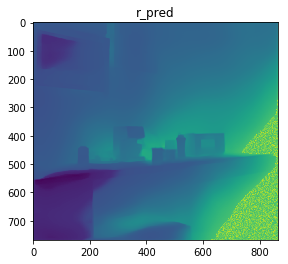

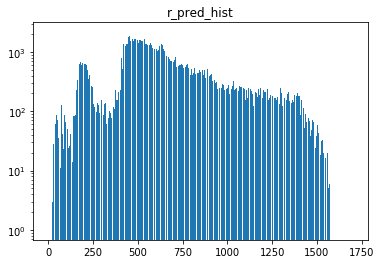

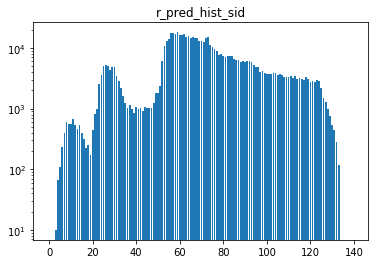

In [108]:
# Histogram Matching (GT, Lin)
r_pred, t = image_histogram_match_lin(r_init, gt_r_hist, np.ones_like(r_init), min_depth, max_depth)
plt.figure()
plt.imshow(r_pred, vmin=min_depth, vmax=max_depth)
plt.title("r_pred")

r_pred_hist = get_lin_hist(r_pred, min_depth, max_depth, max_depth_bin-min_depth_bin)
r_pred_hist_sid = get_sid_hist(r_pred, sid_obj)

plt.figure()
plt.bar(range(len(r_pred_hist)), r_pred_hist, log=True)
plt.title("r_pred_hist")

plt.figure()
plt.bar(range(len(r_pred_hist_sid)), r_pred_hist_sid, log=True)
plt.title("r_pred_hist_sid")

mask = (gt_r >= min_depth).astype('float')
gt_z[gt_z == 0] = 1e-3  # Clip to avoid numerical issues

r_pred_resized = cv2.resize(r_pred, gt_r.shape)
pred_metrics = get_depth_metrics(torch.from_numpy(r_pred_resized).float(),
                  torch.from_numpy(gt_r).float(),
                  torch.from_numpy(mask).float())
pprint_metrics(pred_metrics)

        d1,         d2,         d3,        rel,       rmse,     log_10
    0.7859,     0.9751,     0.9912,     0.1334,     0.5384,     0.0617


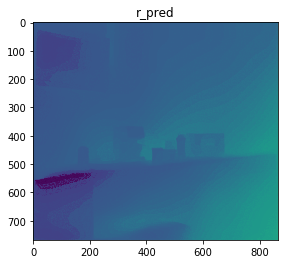

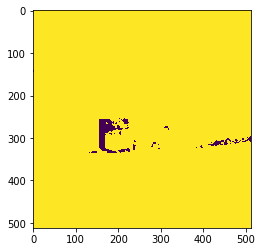

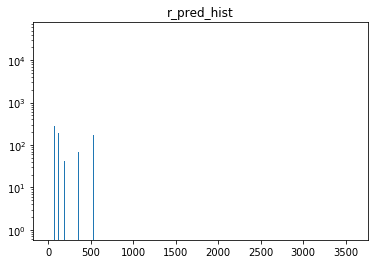

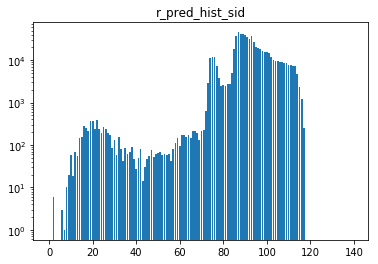

In [135]:
# Histogram Matching (GT, SID)
r_pred, t = image_histogram_match(r_init, gt_r_hist_sid, np.ones_like(r_init), sid_obj)

plt.figure()
plt.imshow(r_pred, vmin=min_depth, vmax=max_depth)
plt.title("r_pred")

plt.figure()
plt.imshow(mask)

r_pred_hist = get_lin_hist(r_pred, min_depth, max_depth, max_depth_bin-min_depth_bin)
r_pred_hist_sid = get_sid_hist(r_pred, sid_obj)

plt.figure()

plt.bar(range(len(r_pred_hist)), r_pred_hist, log=True)
plt.title("r_pred_hist")

plt.figure()
plt.bar(range(len(r_pred_hist_sid)), r_pred_hist_sid, log=True)
plt.title("r_pred_hist_sid")

z_pred = r_to_z(r_pred, fc_kinect)
z_pred_resized = cv2.resize(z_pred, gt_z.shape)
pred_metrics = get_depth_metrics(torch.from_numpy(z_pred_resized).float(),
                  torch.from_numpy(gt_z).float(),
                  torch.from_numpy(mask).float())
pprint_metrics(pred_metrics)


In [151]:

def get_mean(histogram):
    idx = np.array(range(len(histogram)))
    pdf = histogram/np.sum(histogram)
    return np.floor(idx.dot(pdf))

get_mean(spad_sid)

91.0

        d1,         d2,         d3,        rel,       rmse,     log_10
    0.7848,     0.9806,     0.9996,     0.1284,     0.5381,     0.0590


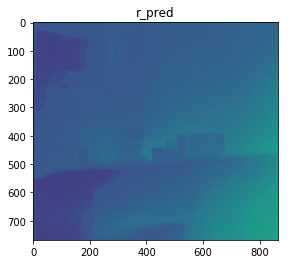

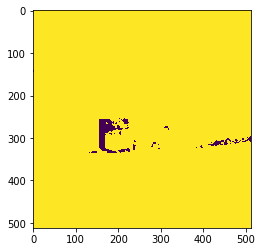

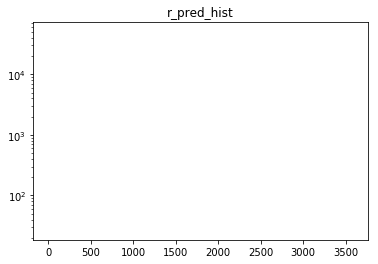

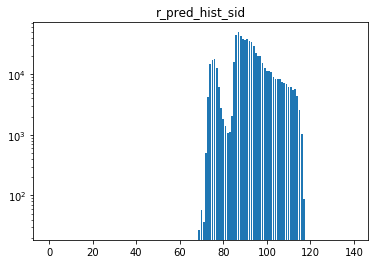

In [137]:
# Histogram Matching (SPAD, SID)
# weights = intensity*cv2.resize(normals, (intensity.shape[1], intensity.shape[0]))
weights = intensity
r_pred, t = image_histogram_match(r_init, spad_sid, weights, sid_obj)

plt.figure()
plt.imshow(r_pred, vmin=min_depth, vmax=max_depth)
plt.title("r_pred")

plt.figure()
plt.imshow(mask)

r_pred_hist = get_lin_hist(r_pred, min_depth, max_depth, max_depth_bin-min_depth_bin)
r_pred_hist_sid = get_sid_hist(r_pred, sid_obj)

plt.figure()
plt.bar(range(len(r_pred_hist)), r_pred_hist, log=True)
plt.title("r_pred_hist")

plt.figure()
plt.bar(range(len(r_pred_hist_sid)), r_pred_hist_sid, log=True)
plt.title("r_pred_hist_sid")

z_pred = r_to_z(r_pred, fc_kinect)
z_pred_resized = cv2.resize(z_pred, gt_z.shape)
pred_metrics = get_depth_metrics(torch.from_numpy(z_pred_resized).float(),
                  torch.from_numpy(gt_z).float(),
                  torch.from_numpy(mask).float())
pprint_metrics(pred_metrics)



In [11]:
# Histogram Matching (Traditional)
def hist_match(source, template):
    """
    From https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x

    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

        d1,         d2,         d3,        rel,       rmse,     log_10
    0.8110,     0.9749,     0.9994,     0.1268,     0.5293,     0.0564


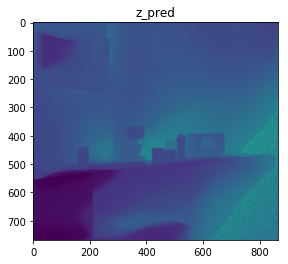

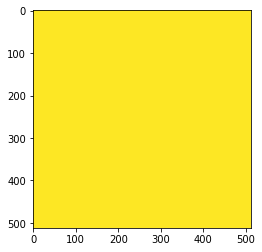

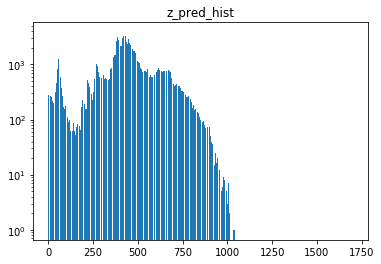

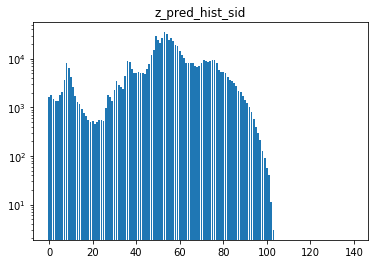

In [109]:
# Try with z instead of r
gt_z = r_to_z(gt_r, fc_spad)
z_pred = r_to_z(r_pred, fc_kinect)

plt.figure()
plt.imshow(z_pred, vmin=min_depth, vmax=max_depth)
plt.title("z_pred")

plt.figure()
plt.imshow(mask)

z_pred_hist = get_lin_hist(z_pred, min_depth, max_depth, max_depth_bin-min_depth_bin)
z_pred_hist_sid = get_sid_hist(z_pred, sid_obj)

plt.figure()
plt.bar(range(len(z_pred_hist)), z_pred_hist, log=True)
plt.title("z_pred_hist")

plt.figure()
plt.bar(range(len(z_pred_hist_sid)), z_pred_hist_sid, log=True)
plt.title("z_pred_hist_sid")

z_pred_resized = cv2.resize(z_pred, gt_z.shape)
pred_metrics = get_depth_metrics(torch.from_numpy(z_pred_resized).float(),
                  torch.from_numpy(gt_z).float(),
                  torch.from_numpy(mask).float())
pprint_metrics(pred_metrics)

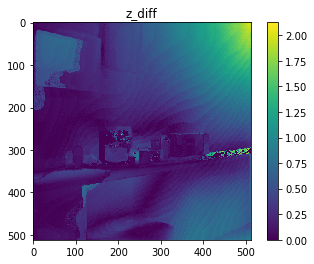

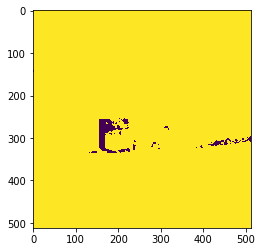

In [138]:
# Diff Maps
z_diff = np.abs(z_pred_resized - gt_z)
plt.figure()
plt.imshow(z_diff*mask)
plt.colorbar()
plt.title("z_diff")
plt.figure()
plt.imshow(mask)

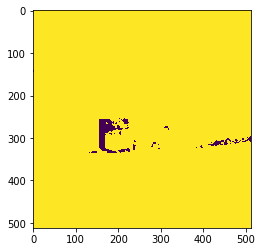

In [139]:
# Save images to files
